In [37]:
import os
import pandas as pd
# import tensorflow_datasets as tfds
from google.colab import drive

In [38]:
# Mount your Google Drive to the Colab virtual machine
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# change director
os.chdir('drive/MyDrive/CSCI5502_dataset')
# print
!pwd

FileNotFoundError: ignored

In [76]:
# students_df = pd.read_excel('StudentInformationTable.xlsx')
rating_df = pd.read_excel('CourseSelectionTable.xlsx')

In [77]:
# drop null values
rating_df.drop('CourseName', axis=1, inplace=True)
rating_df.dropna(axis=0, inplace=True)

In [78]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149021 entries, 0 to 208939
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   StudedntId     149021 non-null  int64  
 1   AcademicYear   149021 non-null  object 
 2   Semester       149021 non-null  float64
 3   CourseId       149021 non-null  int64  
 4   CourseCollege  149021 non-null  object 
 5   Score          149021 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 8.0+ MB


In [79]:
rating_df.head()

,StudedntId,AcademicYear,Semester,CourseId,CourseCollege,Score
0,1115,18-19,1.0,146,National School of Development,81.0
3,1115,18-19,1.0,681,Department of Medicine Teaching office,72.0
4,1115,18-19,1.0,684,Department of Medicine Teaching office,83.5
5,1115,18-19,1.0,748,College of Life Sciences,85.0
6,1115,18-19,1.0,844,College of Life Sciences,75.0


In [80]:
# Number of students
print('The ratings dataset has', rating_df['StudedntId'].nunique(), 'unique students')
# Number of courses
print('The ratings dataset has', rating_df['CourseId'].nunique(), 'unique courses')
# Number of scores
print('The ratings dataset has', rating_df['Score'].nunique(), 'unique scores')
# List of unique scores
print('The unique ratings are', sorted(rating_df['Score'].unique()))

The ratings dataset has 4546 unique students
The ratings dataset has 3639 unique courses
The ratings dataset has 238 unique scores
The unique ratings are [0.0, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 5.5, 6.0, 7.0, 7.5, 8.0, 9.0, 9.5, 10.0, 11.0, 12.0, 12.5, 13.0, 14.0, 14.5, 15.0, 16.0, 16.5, 17.0, 18.0, 19.0, 19.5, 20.0, 20.5, 21.0, 22.0, 22.5, 23.0, 23.5, 23.6, 24.0, 25.0, 25.5, 26.0, 27.0, 27.5, 28.0, 28.5, 29.0, 30.0, 30.5, 31.0, 32.0, 33.0, 34.0, 34.5, 35.0, 35.5, 36.0, 36.5, 37.0, 37.5, 38.0, 38.5, 39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42.5, 43.0, 43.5, 44.0, 44.5, 45.0, 45.5, 46.0, 46.5, 47.0, 47.5, 48.0, 48.5, 49.0, 49.5, 50.0, 50.5, 51.0, 51.5, 52.0, 52.5, 53.0, 53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5, 58.0, 59.0, 59.5, 60.0, 60.5, 61.0, 61.5, 62.0, 62.5, 63.0, 63.5, 64.0, 64.5, 65.0, 65.5, 66.0, 66.5, 66.6, 67.0, 67.5, 68.0, 68.5, 69.0, 69.5, 70.0, 70.5, 70.7, 71.0, 71.5, 72.0, 72.5, 73.0, 73.5, 74.0, 74.5, 75.0, 75.5, 76.0, 76.5, 77.0, 77.5, 78.0, 78.5, 79.

In [81]:
courses_df = pd.read_excel('CourseInformationTable.xlsx')

In [82]:
# drop unnecessary column and null rows
courses_df.drop('Prerequisite', axis=1, inplace=True)
courses_df.dropna(axis=0, inplace=True)
courses_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4896 entries, 0 to 5589
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CourseId      4896 non-null   int64  
 1   CourseName    4896 non-null   object 
 2   College       4896 non-null   object 
 3   Type          4896 non-null   object 
 4   Grade         4896 non-null   float64
 5   Introduction  4896 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 267.8+ KB


In [83]:
df = pd.merge(rating_df, courses_df, on='CourseId', how='inner')

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147296 entries, 0 to 147295
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   StudedntId     147296 non-null  int64  
 1   AcademicYear   147296 non-null  object 
 2   Semester       147296 non-null  float64
 3   CourseId       147296 non-null  int64  
 4   CourseCollege  147296 non-null  object 
 5   Score          147296 non-null  float64
 6   CourseName     147296 non-null  object 
 7   College        147296 non-null  object 
 8   Type           147296 non-null  object 
 9   Grade          147296 non-null  float64
 10  Introduction   147296 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 13.5+ MB


In [85]:
df.head()

,StudedntId,AcademicYear,Semester,CourseId,CourseCollege,Score,CourseName,College,Type,Grade,Introduction
0,1115,18-19,1.0,146,National School of Development,81.0,Advanced Mathematics (B) (1),National School of Development,Required major,5.0,Explanation: Comparing with the introductions ...
1,1108,18-19,1.0,146,National School of Development,79.0,Advanced Mathematics (B) (1),National School of Development,Required major,5.0,Explanation: Comparing with the introductions ...
2,1192,19-20,1.0,146,National School of Development,89.0,Advanced Mathematics (B) (1),National School of Development,Required major,5.0,Explanation: Comparing with the introductions ...
3,1193,19-20,1.0,146,National School of Development,74.0,Advanced Mathematics (B) (1),National School of Development,Required major,5.0,Explanation: Comparing with the introductions ...
4,1293,19-20,1.0,146,National School of Development,89.0,Advanced Mathematics (B) (1),National School of Development,Required major,5.0,Explanation: Comparing with the introductions ...


In [86]:
# Aggregate by score
agg_scores = df.groupby('CourseId').agg(mean_score = ('Score', 'mean'),
                                                number_of_scores = ('Score', 'count')).reset_index()
# Keep the courses with over 100 ratings
agg_scores_GT100 = agg_scores[agg_scores['number_of_scores']>100]
agg_scores_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316 entries, 58 to 3550
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CourseId          316 non-null    int64  
 1   mean_score        316 non-null    float64
 2   number_of_scores  316 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 9.9 KB


In [87]:
# Check popular courses
agg_scores_GT100.sort_values(by='number_of_scores', ascending=False).head()

,CourseId,mean_score,number_of_scores
3521,5508,89.174210,3513
58,146,77.730217,2300
2789,4117,83.326039,2285
59,147,75.248995,2239
2791,4119,84.113606,2227


In [88]:
# Merge Data
df_GT100 = pd.merge(df, agg_scores_GT100[['CourseId']], on='CourseId', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100582 entries, 0 to 100581
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   StudedntId     100582 non-null  int64  
 1   AcademicYear   100582 non-null  object 
 2   Semester       100582 non-null  float64
 3   CourseId       100582 non-null  int64  
 4   CourseCollege  100582 non-null  object 
 5   Score          100582 non-null  float64
 6   CourseName     100582 non-null  object 
 7   College        100582 non-null  object 
 8   Type           100582 non-null  object 
 9   Grade          100582 non-null  float64
 10  Introduction   100582 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 9.2+ MB


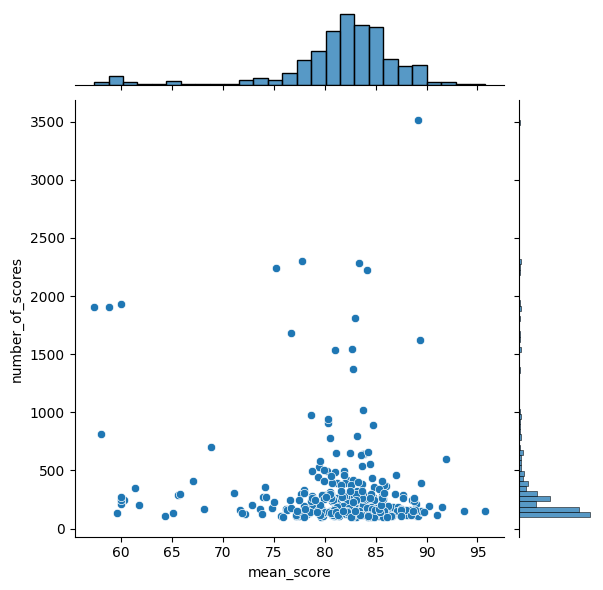

In [89]:
import seaborn as sns

# Visulization
sns.jointplot(x='mean_score', y='number_of_scores', data=agg_scores_GT100)